# Grover’s algorithm

Grover’s algorithm, introduced by Lov Grover, is a quantum algorithm designed for search problems that rely on an oracle. In its original formulation, the problem is described as follows: suppose we want to locate a specific phone number within an unsorted directory containing  N  entries. In classical computation, locating this number with a probability of  $\frac{1}{2}$ would require checking, on average, $\frac{N}{2}$  entries.

More generally, Grover's algorithm addresses the problem of locating a target item within a list of N items, assuming access to an oracle function f(x) . This oracle function is defined such that f(x) = 1 if x is the sought-after item, and f(x) = 0 otherwise. Grover’s quantum algorithm enables us to solve this problem by querying the oracle approximately $O\sqrt{N}$ times, providing a high probability of finding the target item. This is a significant improvement over any classical approach, which would require O(N) queries to achieve the same result.

The algorithm can be broken down into the following steps:

1. Prepare the initial state
2. Implement the oracle
3. Apply the Grover diffusion operator
4. Repeat steps 2 and 3 approximately $\frac{\pi}{4} \sqrt{N}$ times
5. Measure

In [19]:
# Let’s import the usual PennyLane and Numpy libraries to load the necessary functions:

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

# Preparing the Initial State

In [2]:
NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))


In [3]:
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state")
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After applying the Hadamard gates: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


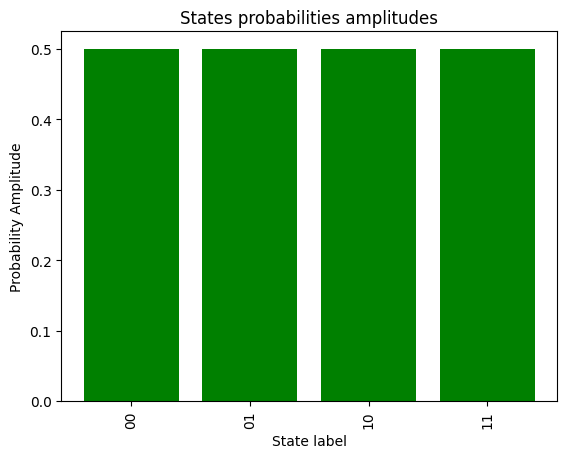

In [9]:
y = np.real(results["After applying the Hadamard gates"])
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y, color = "green")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
plt.show()

# The Oracle and Grover’s diffusion operator

In [11]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state |00>")
    # Flipping the marked state
    qml.FlipSign([0, 0], wires=wires)
    qml.Snapshot("After flipping it")
    return qml.state()

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state |00>: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After flipping it: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
execution_results: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


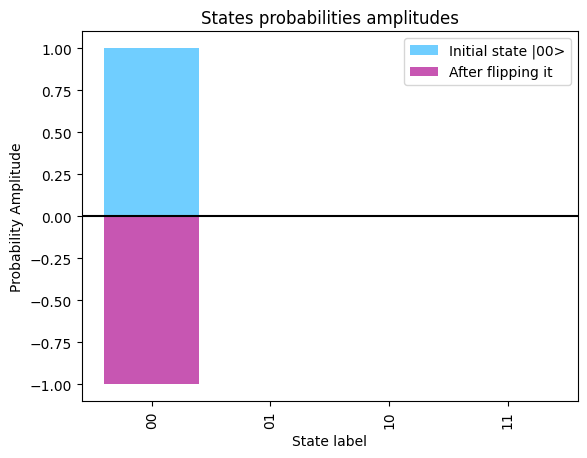

In [12]:
y1 = np.real(results["Initial state |00>"])
y2 = np.real(results["After flipping it"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y1, color = "#70CEFF")
plt.bar(bit_strings, y2, color = "#C756B2")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend(["Initial state |00>", "After flipping it"])
plt.axhline(y=0.0, color="k", linestyle="-")
plt.show()

In [13]:
omega = np.zeros(NUM_QUBITS)

def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


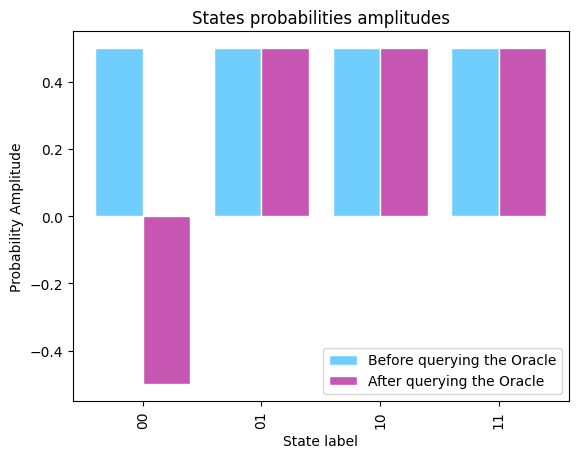

In [14]:
y1 = np.real(results["Before querying the Oracle"])
y2 = np.real(results["After querying the Oracle"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend()
plt.show()

In [15]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)


def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)


@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Uniform superposition |s>: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
State marked by Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
Amplitude after diffusion: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
execution_results: [1. 0. 0. 0.]


# Searching for more items in a bigger list

In [16]:
NUM_QUBITS = 5

omega = np.array([np.zeros(NUM_QUBITS), np.ones(NUM_QUBITS)])

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)


results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

execution_results: [0.48065948 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.48065948]


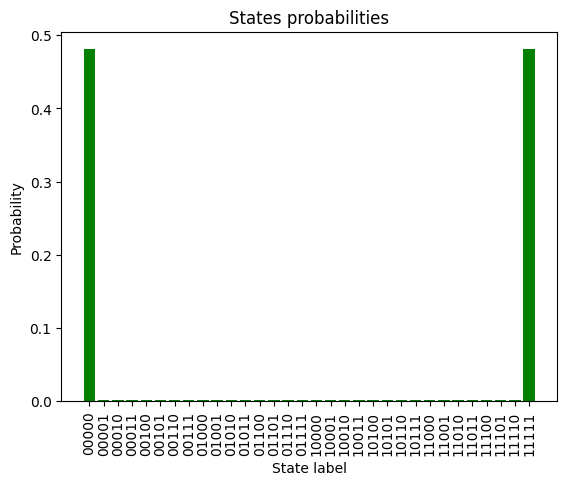

In [18]:
y = results["execution_results"]
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, results["execution_results"], color = "green")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability")
plt.title("States probabilities")

plt.show()